In [1]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()
groq_api_key=os.getenv('GROQ_API_KEY')
TRAVILY_API_KEY=os.getenv('TRAVILY_API_KEY')
LLM=ChatGroq(model='llama-3.1-8b-instant',api_key=groq_api_key)

langchain_key = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = langchain_key
os.environ['LANGCHAIN_TRACING_V2'] = 'true' 
os.environ['LANGCHAIN_PROJECT'] = "ReAct_Agent"


from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
#Import wrapper
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
api_wrapper_wiki=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_wiki)
arxiv.invoke("attention is all you need")

api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.invoke("what is machine learning?")

from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults(api_key=TRAVILY_API_KEY)
tavily.invoke("What is the capital of France?")

#combine all tools
tools=[arxiv,wiki,tavily]
llm_with_tools=LLM.bind_tools(tools)

#add Nodes and edges
from langchain_core.messages import AnyMessage,HumanMessage
llm_with_tools.invoke([HumanMessage(content="What is the tody's Tesla stock price?")])

c:\Gen-Agent-AI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
python-dotenv could not parse statement starting at line 2
C:\Users\a864911\AppData\Local\Temp\ipykernel_29420\758957082.py:27: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults(api_key=TRAVILY_API_KEY)


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'm90rk02bb', 'function': {'arguments': '{"query":"Tesla stock price today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 557, 'total_tokens': 578, 'completion_time': 0.038999431, 'completion_tokens_details': None, 'prompt_time': 0.033024888, 'prompt_tokens_details': None, 'queue_time': 0.077098652, 'total_time': 0.072024319}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c4251-720e-7172-8eaa-7020163ca9f7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Tesla stock price today'}, 'id': 'm90rk02bb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 557, 'output_tokens': 21, 'total_tokens': 578})

In [2]:
#custom function
def addition(a:int,b:int)->int:
    '''
        This function takes two integers as input and returns their sum.3
        Parameters:
        a (int): The first integer. 
        b (int): The second integer.
        Returns:
        int: The sum of the two integers.
    '''
    return a+b

def substraction(a:int,b:int)->int:
    '''
        This function takes two integers as input and returns their difference.
        Parameters:
        a (int): The first integer. 
        b (int): The second integer.
        Returns:
        int: The difference of the two integers.
    '''
    return a-b

def division(a:int,b:int)->int:
    '''
        This function takes two integers as input and returns their quotient.
        Parameters:
        a (int): The first integer. 
        b (int): The second integer.
        Returns:
        int: The quotient of the two integers.
    '''
    return a/b


In [3]:
tools=[wiki,arxiv,tavily,addition,substraction,division]

In [4]:
from typing_extensions import TypedDict
from typing import List,Annotated
from langchain_core.messages import AnyMessage,HumanMessage
from langgraph.graph.message import add_messages

class TypeDictClass(TypedDict):
    messages:Annotated[list, add_messages]

In [10]:
from langgraph.graph import StateGraph,START
from langgraph.prebuilt import ToolNode,tools_condition
builder=StateGraph(TypeDictClass)

def llm_with_tools_func(state):
    return {"messages":llm_with_tools.invoke(state["messages"])}

#adding node 
builder.add_node(llm_with_tools_func, "llm_with_tools_func")
builder.add_node("tools",ToolNode(tools=tools))
#adding edges
builder.add_edge(START, "llm_with_tools_func")
builder.add_conditional_edges("llm_with_tools_func",tools_condition)
builder.add_edge("tools","llm_with_tools_func")

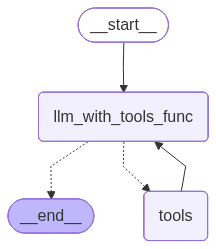

In [14]:
graph_=builder.compile()
graph_

In [13]:
response=graph_.invoke({"messages":[HumanMessage(content="Provide me latest new's on AI,add 5 plus 5 and then ,divide it by 2")]})
for n in response["messages"]:
    n.pretty_print()

================================ Human Message =================================

Provide me latest new's on AI,add 5 plus 5 and then ,divide it by 2
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (sf0xxgb4k)
 Call ID: sf0xxgb4k
  Args:
    query: latest news AI
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | Latest News | Insights Powering AI-Driven Business Growth", "url": "https://www.artificialintelligence-news.com/", "content": "TechEx Events\n\nFebruary 4, 2026\n\n#### Industries\n\n### AI use surges at Travelers as call centre roles reduce\n\nAI Business Strategy\n\nJanuary 30, 2026\n\n### Cold snap highlight’s airlines’ proactive use of AI\n\nService Industry AI\n\nJanuary 27, 2026\n\n### Retailers examine options for on-AI retail\n\nRetail & Logistics AI\n\nJanuary 26, 2026\n\n#### Deep Learning\n\n### IBM Research 

In [17]:
#Agent Memory
response=graph_.invoke({"messages":[HumanMessage(content="What is addition of 5 and 8?")]})
for n in response["messages"]:
    n.pretty_print()

================================ Human Message =================================

What is addition of 5 and 8?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (rrq76a7rt)
 Call ID: rrq76a7rt
  Args:
    query: addition of 5 and 8
================================= Tool Message =================================
Name: wikipedia

Page: Addition
Summary: Addition, usually denoted with the plus sign +, is one of the four basic operations of arithmetic, the other three being subtraction, multiplication, and division. The addition of two whole numbers results in the total or sum of those values combined. For example, the adjacent image shows two columns of apples, one with three apples and the other with two apples, totaling to five apples. This observation is expressed as "3 + 2 = 5", which is read as  "three plus two equal
================================== Ai Message ==================================
Tool Calls:
  tavily_search_resul

In [19]:
messages=HumanMessage(content="divide that number by 2")
response=graph_.invoke({"messages":messages})
for n in response["messages"]:
    n.pretty_print()

================================ Human Message =================================

divide that number by 2
================================== Ai Message ==================================

I'm not sure what number you would like me to divide by 2. Could you please provide the number?


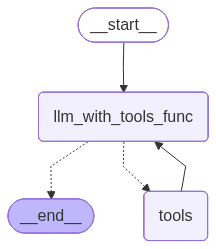

In [20]:
#Agent Memory
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_memory=builder.compile(checkpointer=memory)
graph_memory

In [26]:
#create thread
config={"configurable":{"thread_id":"thread_1"}}
messages=HumanMessage(content="What is addition of 5 and 8?")
response=graph_memory.invoke({"messages":messages},config=config)
for n in response["messages"]:
    n.pretty_print()

================================ Human Message =================================

addition of 12 and 15
================================ Human Message =================================

addition of 12 and 15
================================ Human Message =================================

What is addition of 5 and 8?
================================== Ai Message ==================================
Tool Calls:
  arxiv (96ta86rve)
 Call ID: 96ta86rve
  Args:
    query: addition of 5 and 8
================================= Tool Message =================================
Name: arxiv

Published: 2022-03-14
Title: The Project 8 Neutrino Mass Experiment
Authors: Project 8 Collaboration, A. Ashtari Esfahani, S. Böser, N. Buzinsky, M. C. Carmona-Benitez, C. Claessens, L. de Viveiros, P. J. Doe, S. Enomoto, M. Fertl, J. A. Formaggio, J. K. Gaison, M. Grando, K. M. Heeger, X. Huyan, A. M. Jones, K. Kazkaz, M. Li, A. Lindman, C. Matthé, R. Mohiuddin, B. Monreal, R. Mueller, J. A. Nikkel, E. Novitski

In [27]:
messages=HumanMessage(content="divide that number by 2")
resposne =graph_memory.invoke({"messages":messages},config=config)
for n in resposne["messages"]:
    n.pretty_print()

================================ Human Message =================================

addition of 12 and 15
================================ Human Message =================================

addition of 12 and 15
================================ Human Message =================================

What is addition of 5 and 8?
================================== Ai Message ==================================
Tool Calls:
  arxiv (96ta86rve)
 Call ID: 96ta86rve
  Args:
    query: addition of 5 and 8
================================= Tool Message =================================
Name: arxiv

Published: 2022-03-14
Title: The Project 8 Neutrino Mass Experiment
Authors: Project 8 Collaboration, A. Ashtari Esfahani, S. Böser, N. Buzinsky, M. C. Carmona-Benitez, C. Claessens, L. de Viveiros, P. J. Doe, S. Enomoto, M. Fertl, J. A. Formaggio, J. K. Gaison, M. Grando, K. M. Heeger, X. Huyan, A. M. Jones, K. Kazkaz, M. Li, A. Lindman, C. Matthé, R. Mohiuddin, B. Monreal, R. Mueller, J. A. Nikkel, E. Novitski